This notebook is an implementation of deep learning. I have learnt and implemented many deep learning models from scratch. I just wanted to have deep understanding about all models and also to pratice python so I decided to do anything from zero. But so far I have never done any real model myself from processing/loading to training.

I started with segmentation problem with pneumonia medical imageson kaggle. Of course, all people start with kaggle, source of data, source of training. And processing/loading turns out not trivial. I finally managed to do it, and decided that I should start with a classification problem.

Well, I chose SqueezeNet because it is small. Training with a big model at the beginning will take me several days that I don't want to stuck in. 

Of course I had to change a bit the model to adapt my problem. First I need to resize my images to 224\*224, then I  replace the last Average Pooling by a fully connected layer to 2 scores since I have only 2-class data. But when I try this modified SqueezeNet to medical images, it works just like random guess.

Well, I try an other modification. In stead of using the convolution layer 1\*1-kernel, I use 3\*3-kernel with the hope that it captures better spatial correlation. And voila, my model worked.

I wrote this note to present the last model I found. I don't even use any augementation techniques and I already got about 80% accuracy to my medical images. 

Let's see it in details.

In [1]:
import glob, pylab, pandas as pd
import numpy as np

from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from skimage import io, transform
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import pydicom


import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda')
dtype = torch.float32 

import warnings
warnings.filterwarnings("ignore")


/home/minh/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
!ls ../Data/all/

dog_cat				     stage_2_test_images.zip
GCP Credits Request Link - RSNA.txt  stage_2_train_images
stage_2_detailed_class_info.csv      stage_2_train_images.zip
stage_2_sample_submission.csv	     stage_2_train_labels.csv
stage_2_test_images


In [3]:
info_dir='stage_2_detailed_class_info.csv'
image_dir='stage_2_train_images'

I did one small prescriptive analysis of the data. I don't do it again here, but still show some information to have an idea about my data. So we show the head of the data.

In [4]:
df = pd.read_csv('../Data/all/'+info_dir)
df.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [5]:
df.describe()

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     0d5bc737-03de-4bb8-98a1-45b7180c3e0f  No Lung Opacity / Not Normal
freq                                       4                         11821

In [6]:
df=df.replace(["No Lung Opacity / Not Normal","Normal"],0)
df=df.replace(["Lung Opacity"],1)
df.rename(columns={'class': 'Target'},inplace=True)
df.head()

patientId  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0
2  00322d4d-1c29-4943-afc9-b6754be640eb       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0
4  00436515-870c-4b36-a041-de91049b9ab4       1

Let's show one image.

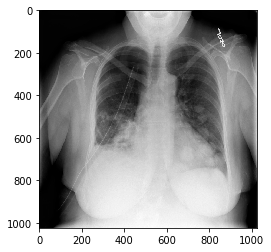

In [7]:
patient0=df.patientId[0]
patient0_file='../Data/all/'+image_dir+'/%s.dcm' % patient0
image0_data = pydicom.read_file(patient0_file)
image0 = image0_data.pixel_array
pylab.imshow(image0, cmap=pylab.cm.gist_gray)

The image is of lungs taken from front. I've done a small descriptive analysis here.  

I would like to load and process data in order to prepare for training a neural network. I start with the simplest process where there is neither transfromation nor augemetation to data.

In [8]:
class PneuDataset(Dataset):
    """Pneunomia dataset."""

    def __init__(self, FileName_data, img_dir, transform=None):
        """
        Args:
            FileName_data: Data frame with filenames of images.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = FileName_data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient=self.df.patientId[idx]
        patient_file = os.path.join(self.img_dir,patient)+'.dcm'
        image = pydicom.read_file(patient_file).pixel_array
        label=self.df.Target[idx]
        
        if self.transform:
            image=self.transform(image)
        
        image = np.expand_dims(image, axis=0)
        
        return image, label

The following function is used to check accuracy on validation set. It simply calculates the rate of correct predition over total validation test.

In [60]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f), and loss %.4f' % (num_correct, num_samples, 100 * acc, loss.item()))
        return acc, loss.item()

In [10]:
def save_checkpoint(state, is_best, filename='checkpoint_Squeeze_Pneu.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [10]:
from livelossplot import PlotLosses


In [61]:
# optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
#                      momentum=0.9, nesterov=True)

def train(model, optimizer, epochs=1):
    """
    Train a model.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    liveloss = PlotLosses()    
    best_loss=100
    learning_rate=1e-3
    
    loss_avg=0
    acc_avg=0
    
    for e in range(epochs):
        
        for t, (x, y) in enumerate(loader_train):
                           
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if (t+e*len(loader_train)+1) % decay_every == 0:
                learning_rate*=decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = learning_rate
                
                loss_avg*=(print_every/decay_every)
                acc_avg*=(print_every/decay_every)
                
                              
                if (loss_avg<1e-6 or (1-acc_avg)<1e-6):
                    print('Overift at epoch %d and iteration %d' %(e,t))
                    return
                loss_avg=0
                acc_avg=0
            

            if (t+e*len(loader_train)) % print_every == 0:
                acc,_=check_accuracy(loader_train, model)
                acc_val, loss_val=check_accuracy(loader_val, model)
                
                               
                loss_avg+=loss.item()
                acc_avg+=acc
                
                if best_loss> loss_val:
                    torch.save({
                            'epoch': e + 1,
                            'iteration': t+1,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict(),
                        }, 'checkpoint_Squeeze_Pneu.pth.tar')
                
                liveloss.update({
                    'loss': loss.item(),
                    'val_loss': loss_val,
                    'accuracy': acc,
                    'val_accuracy': acc_val
                })
                liveloss.draw()

                                
                

I will implement a transformation to dataset and re-train the model above. I implement only two transformation: a resizing, flipping, and their combination. 

In [14]:

#Transform an image
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        if isinstance(self.output_size, int):
            new_h, new_w=self.output_size, self.output_size 
        else:
            new_h, new_w = self.output_size

        img = transform.resize(image, (new_h, new_w))

        return img

I will load one pretrained model and modify some layers, then train the modified model. I choose the squeezenet because of its simpleness. 

In [13]:
squeezenet = models.squeezenet1_0()

I would like to check all layers of the SqueezeNet. So I print each layer out.

In [13]:
child_counter = 0
for child in squeezenet.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation):

SqueezeNet reduces the number of parameters by two techniques: replace big convolution by $1\times 1$ convolution layers which is called squeeze step; reduce the number of channels corresponding to the big convolution. For the tradeoff issue complexity-accuracy, it says that if we reduce the complexity we pay by also reduce the accuracy. So to maintain the accuracy they postpone the downsample late in the network. 

So instead of using a conventional convolution layer, for example $3\times 3$-size, they replace it by a so called fire layer consisting of one queezed stage and one expanded stage, the squeezing reduces the number of input channels, and the expanding recovers the output channel but by two blocks, one with $1\times 1$ convolution and the rest with $3 \times 3$. 

Let's look at one layer to illustrate for the above analysis. If we, for example, use a $3\times 3$ convolution layer to treat the input $55\times 55\times 96$ with the output $55\times 55\times 128$ we have $(3\times 3\times 3\times 96+1)\times 128 = 110720$ parameters. Now we first use a $1\times 1$ convolution to reduce the input channel 96 down to 16, then a $1\times 1$ one to cover 96 output channels and a $3\times 3$ one to complement the rest 96 output channels, we finally get the same dimention output, but the number of parameters is $(1\times 1\times 96+1)\times 16+(1\times 1\times 16+1)\times 64+(3\times 3\times 16+1)\times 64=11920$, 9 times smaller.

So as listed, SqueezeNet is:
convolution -> MaxPool -> (fire) $\times 3$ -> Maxpool -> (fire) $\times 4$ -> MaxPool -> fire -> Dropout -> convolution -> AvgPool

Now I would like to adopt SqueezeNet to my problem. I start with the smallest modification: input channel of the first layer. Because my image is not BRG but only one channel. I will also resize image to $224\times 224$ and add one convolution layer 3\*3 then a fully connected layer to get 2 scores since we have only 2 classes. 

In [15]:
conv1=nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
child0=list(squeezenet.children())[0]
fire=child0[1:]
child1=list(squeezenet.children())[1]
child11=child1[1:-1]

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model_modified=nn.Sequential(
    conv1,
    fire,
    child11,
    nn.Conv2d(1000, 96, kernel_size=(3, 3), stride=(1, 1),padding=1),
    Flatten(),
    nn.Linear(13*13*96,2)
    )

Let's check again our model's architecture.

In [15]:
child_counter = 0
for child in model_modified.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
 child 1 is:
Sequential(
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activa

I will train the new model with a  sample. Let's check 500 samples with 400 training ones and 100 for validation.

In [50]:
FileName_500=df[:500]
img_dir='../Data/all/'+image_dir
dataset_transformed=PneuDataset(FileName_data=FileName_500, img_dir=img_dir, transform=Rescale(224))

train_size = 400
val_size = 100

train_dataset_500, val_dataset_500 = torch.utils.data.random_split(dataset_transformed, [train_size, val_size])

loader_train = DataLoader(train_dataset_500, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_dataset_500, batch_size=4,
                        shuffle=True)

In [17]:
FileName_500[FileName_500.Target==1].count()

patientId    225
Target       225
dtype: int64

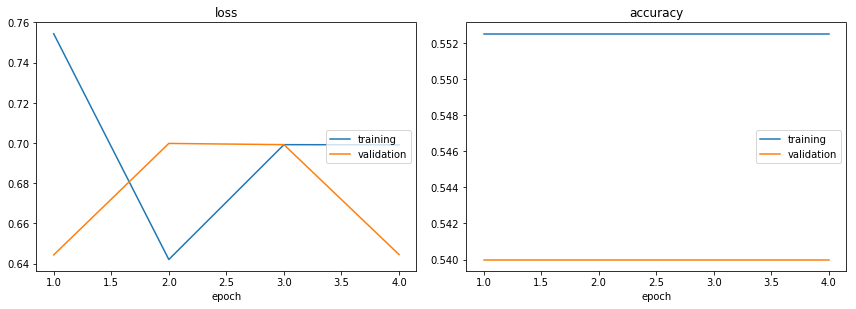

In [62]:
device='cuda'
# learning_rate = 1e-3
print_every=100
decay=0.1
decay_every=print_every*2

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
        
model_modified.apply(weights_init)

optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


train(model_modified, optimizer,epochs=4)

In [58]:
model = nn.Sequential(
    conv1,
    fire,
    child11,
    nn.Conv2d(1000, 96, kernel_size=(3, 3), stride=(1, 1),padding=1),
    Flatten(),
    nn.Linear(13*13*96,2)
    )
optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
checkpoint = torch.load('checkpoint_Squeeze_Pneu.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
model = model.to(device=device) 
check_accuracy(loader_val, model)

(0.54, 0.6439859867095947)

In [59]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])
    print(1e-3)

0.0001
0.001


So I've got 89 correct prediction over 100 samples. Let's check the accuracy on the training set.

In [21]:
check_accuracy(loader_train, model_modified)

Got 391 / 400 correct (97.75), and loss 0.0183


A bit overfit. I will check the regularisation with another notebook, let's keep this model but train with all data we have.

In [19]:
img_dir='../Data/all/'+image_dir
dataset_full_transformed=PneuDataset(FileName_data=df, img_dir=img_dir, transform=Rescale(224))

loader_full = DataLoader(dataset_full_transformed, batch_size=4,
                        shuffle=True)

In [22]:
check_accuracy(loader_full, model_modified)

Got 21172 / 30227 correct (70.04), and loss 0.0081


In [23]:
torch.save(model_modified, 'Squeezenet_Kernel3_100e_500Samples.pt')

In [25]:
data_size=len(df)
training_size = int(0.8*data_size)
test_size = data_size-training_size

train_size=int(0.8*training_size)
val_size=training_size-train_size

train_dataset, val_dataset, test_set = torch.utils.data.random_split(dataset_full_transformed, [train_size, val_size,test_size])

loader_train = DataLoader(train_dataset, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_dataset, batch_size=4,
                        shuffle=True)

Let's play a bit with training step. I check results on my test set and the model seems not to be overfitted because the loss on trained and validated sets are quite similar. I also check the accuracy of test set. The validation set's accuracy is arount 82% while the test set'one is arount 80%.

In [120]:
device='cuda'
learning_rate = 0.05e-3
print_every=1000

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)
        
# model_modified.apply(weights_init)


optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=10)

Iteration 0, epoch 0, loss = 0.4303
Got 3943 / 4837 correct (81.52), and loss 0.1240

Iteration 1000, epoch 0, loss = 0.7052
Got 3923 / 4837 correct (81.10), and loss 0.0303

Iteration 2000, epoch 0, loss = 0.2420
Got 3965 / 4837 correct (81.97), and loss 0.1381

Iteration 3000, epoch 0, loss = 0.0260
Got 3890 / 4837 correct (80.42), and loss 0.0342

Iteration 4000, epoch 0, loss = 0.8931
Got 3902 / 4837 correct (80.67), and loss 0.0148

Iteration 164, epoch 1, loss = 0.3099
Got 3942 / 4837 correct (81.50), and loss 0.2895

Iteration 1164, epoch 1, loss = 0.0302
Got 3940 / 4837 correct (81.46), and loss 0.0009

Iteration 2164, epoch 1, loss = 0.1087
Got 3936 / 4837 correct (81.37), and loss 1.0708

Iteration 3164, epoch 1, loss = 0.3377
Got 3954 / 4837 correct (81.74), and loss 0.0973

Iteration 4164, epoch 1, loss = 0.0202
Got 3946 / 4837 correct (81.58), and loss 0.0000

Iteration 328, epoch 2, loss = 0.0793
Got 3960 / 4837 correct (81.87), and loss 0.0097

Iteration 1328, epoch 2, l

In [113]:
loader_test = DataLoader(test_set, batch_size=4,
                        shuffle=True)

In [114]:
check_accuracy(loader_test, model_modified) #after 10 epochs, leraning_rate=0.001

Got 4807 / 6046 correct (79.51), and loss 0.3993


In [116]:
check_accuracy(loader_full, model_modified)#after 2 epochs, leraning_rate=0.0005

Got 24755 / 30227 correct (81.90), and loss 0.8864


In [119]:
check_accuracy(loader_test, model_modified)#after 10 epochs, leraning_rate=0.0001

Got 4878 / 6046 correct (80.68), and loss 0.2266


So this time I will check augmentation. Our images are always photographed at nearly same position (to capture both lungs), so I used only the flip augmentation. Let's see if the game changes.

In [48]:
class RandomFlip(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        if torch.rand(1)>0.5:
#             image = np.fliplr(image)
            torch.from_numpy(np.flip(image,axis=0).copy())
        return image
    

In [50]:
dataset_aug=PneuDataset(FileName_data=FileName_500, img_dir=img_dir, 
                        transform=transforms.Compose([Rescale(224),RandomFlip()]))


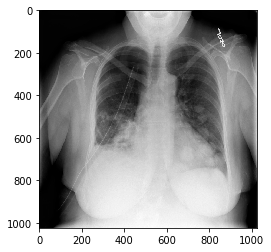

In [49]:
flip=RandomFlip()
pylab.imshow(flip(image0), cmap=pylab.cm.gist_gray)

In [51]:
train_size = 400
val_size = 100

train_aug_500, val_aug_500 = torch.utils.data.random_split(dataset_aug, [train_size, val_size])

loader_train = DataLoader(train_aug_500, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_aug_500, batch_size=4,
                        shuffle=True)

In [53]:
device='cuda'
learning_rate = 1e-3
print_every=500

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)
        
# model_modified.apply(weights_init)


optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=100)

Iteration 0, epoch 0, loss = 0.0194
Got 82 / 100 correct (82.00), and loss 0.4829

Iteration 0, epoch 5, loss = 0.2804
Got 78 / 100 correct (78.00), and loss 0.4623

Iteration 0, epoch 10, loss = 0.0472
Got 83 / 100 correct (83.00), and loss 0.0013

Iteration 0, epoch 15, loss = 0.1868
Got 80 / 100 correct (80.00), and loss 0.4494

Iteration 0, epoch 20, loss = 0.0310
Got 83 / 100 correct (83.00), and loss 0.2389

Iteration 0, epoch 25, loss = 0.0014
Got 86 / 100 correct (86.00), and loss 0.4879

Iteration 0, epoch 30, loss = 0.0003
Got 82 / 100 correct (82.00), and loss 0.2855

Iteration 0, epoch 35, loss = 0.0168
Got 86 / 100 correct (86.00), and loss 0.0003

Iteration 0, epoch 40, loss = 0.0000
Got 86 / 100 correct (86.00), and loss 0.3649

Iteration 0, epoch 45, loss = 0.0002
Got 86 / 100 correct (86.00), and loss 0.0404

Iteration 0, epoch 50, loss = 0.0003
Got 86 / 100 correct (86.00), and loss 0.4145

Iteration 0, epoch 55, loss = 0.0004
Got 86 / 100 correct (86.00), and loss 3.

In [54]:
check_accuracy(loader_full, model_modified)

Got 22171 / 30227 correct (73.35), and loss 0.0642


It is promising. The model predicts better than the one without the augmentation. So we will train the model with full data. Let's cross fingers.

In [55]:
dataset_aug_full=PneuDataset(FileName_data=df, img_dir=img_dir, 
                        transform=transforms.Compose([Rescale(224),RandomFlip()]))

In [56]:
data_size=len(df)
training_size = int(0.8*data_size)
test_size = data_size-training_size

train_size=int(0.8*training_size)
val_size=training_size-train_size

train_aug, val_aug, test_aug = torch.utils.data.random_split(dataset_aug_full, [train_size, val_size,test_size])

loader_train = DataLoader(train_aug, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_aug, batch_size=4,
                        shuffle=True)

In [62]:
device='cuda'
learning_rate = 1e-4
print_every=1000

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)
        
# model_modified.apply(weights_init)


optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=10)

Iteration 0, epoch 0, loss = 0.0578
Got 3764 / 4837 correct (77.82), and loss 0.0359

Iteration 1000, epoch 0, loss = 0.9237
Got 3779 / 4837 correct (78.13), and loss 0.2621

Iteration 2000, epoch 0, loss = 0.2991
Got 3787 / 4837 correct (78.29), and loss 0.1607

Iteration 3000, epoch 0, loss = 0.0448
Got 3796 / 4837 correct (78.48), and loss 0.3617

Iteration 4000, epoch 0, loss = 0.1748
Got 3800 / 4837 correct (78.56), and loss 0.1336

Iteration 164, epoch 1, loss = 0.4029
Got 3789 / 4837 correct (78.33), and loss 0.1267

Iteration 1164, epoch 1, loss = 0.8085
Got 3807 / 4837 correct (78.71), and loss 1.0169

Iteration 2164, epoch 1, loss = 0.1025
Got 3790 / 4837 correct (78.35), and loss 0.3999

Iteration 3164, epoch 1, loss = 0.6653
Got 3812 / 4837 correct (78.81), and loss 0.3752

Iteration 4164, epoch 1, loss = 0.4804
Got 3806 / 4837 correct (78.69), and loss 0.9791

Iteration 328, epoch 2, loss = 0.1862
Got 3809 / 4837 correct (78.75), and loss 0.1599

Iteration 1328, epoch 2, l

In [59]:
loader_test = DataLoader(test_set, batch_size=4,
                        shuffle=True)

In [60]:
check_accuracy(loader_train, model_modified) #l_r=1e-3, epochs=11, acc=78%

Got 15207 / 19344 correct (78.61), and loss 0.2254


In [61]:
check_accuracy(loader_test, model_modified) #l_r=1e-3, epochs=11, acc=78%

Got 4777 / 6046 correct (79.01), and loss 1.5097


This simple augmentation doesn't affect much our model and training.

So finally, I found that it is very hard for find a good model to a certain data. When I use plain SqueezeNet, the model seems not to work at all, but only one small modification (from 1 size convolution to 3-size convolution), the model correctly predicts about 80% data. The augmentation in this case doesn't play strongly because the model never overfits. And it is also the case for the regulization, I added L2 regularization to the loss, and the training gives quite similar results. Perhaps I haven't trained the model a lot, the situation may change if we keep training. However, I just want to play with models not training so it is fine for now. Because I want to move to the original problem: object detection.

I would like to work with a small model to object detection. I found some literature about SqueezeNet for object detection, so I will try it first for our model. It will be presented in another notebook.